In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.express as px
from plotly.offline import iplot

# Land Geometric Class

In [25]:
class LandGeometric: # this can be changed in the future, but test for now
    def __init__(self, deck_size, card_count_range, cards_drawn_range, pmf_dict=None):
        self.deck_size = deck_size
        self.card_count_range = card_count_range
        self. cards_drawn_range = cards_drawn_range
        if pmf_dict is None:
            self.pmf_dict = {}
        else:
            self.pmf_dict = pmf_dict
        
    def pmf_dist_create(self, 
                        card_count,
                        cards_drawn,
                        deck_size=None):
        # creates a pmf 
        # M = deck_size
        # n = card_count
        # N = cards_drawn
        
        if deck_size is None:
            deck_size = self.deck_size
        
        rv = scipy.stats.hypergeom(deck_size, card_count, cards_drawn)
        x = np.arange(0, cards_drawn+1)
        pmf = rv.pmf(x)
        return pmf
    
    def create_pmf_dict(self, 
                        card_count_range=None,
                        cards_drawn_range=None):
    # loop through cards drawn range
    # loop through card count range
    
        if card_count_range is None:
            card_count_range = self.card_count_range
        if cards_drawn_range is None:
            cards_drawn_range = self.cards_drawn_range
            
        pmf_dict = {}
        
        for card_drawn in cards_drawn_range:
            pmf_dict[card_drawn] = {}
            for card_count in card_count_range:
                pmf_dist = self.pmf_dist_create(card_count, card_drawn)
                pmf_dict[card_drawn][card_count] = pmf_dist
        
        self.pmf_dict = pmf_dict
        # return pmf_dict
    
    def land_count_pmf_array(self, pmf_dict=None):
        if pmf_dict is None:
            pmf_dict = self.pmf_dict
        
        land_count_array_dict = {}
        for key, value in pmf_dict.items():
            land_count_array_dict[key] = {}
            item_nums = len(list(value.values())[0])
            item_range = np.arange(0, item_nums)
            for item_num in item_range:
                land_count_array_dict[key][item_num] = [item[item_num] for item in pmf_dict[key].values()]
        
        self.land_count_pmf_array_dict = land_count_array_dict
        # return land_count_array_dict
    
    def list_delta(self, list_of_num):
        list_delta = [abs(y - x) for x, y in zip(list_of_num, list_of_num[1:])]
        return list_delta
    
    def create_pmf_df(self,
               land_count_pmf_array_dict=None, card_count_range_start=None):
        # function converts pmf dictionary to dataframe
        if land_count_pmf_array_dict is None:
            land_count_pmf_array_dict = self.land_count_pmf_array_dict
            
        if card_count_range_start is None:
            card_count_range_start = self.card_count_range[0]
        
        rows = []
        # convert this to a function
        # vectorize for loop in the future
        for drawn, values in land_count_pmf_array_dict.items():
            cards_drawn = drawn
            for card_count, array in values.items():
                for num, value in enumerate(array, card_count_range_start):
                    # having enumerate start at card count range
                    row_dict = {}
                    row_dict['card_found_pctge'] = value
                    row_dict['land_count'] = num
                    row_dict['cards_drawn'] = cards_drawn
                    row_dict['card_count'] = card_count
                    rows.append(row_dict)
                    
        pmf_dataframe = pd.DataFrame(rows)
        self.pmf_df = pmf_dataframe
        
        return pmf_dataframe

In [26]:
test_geo = LandGeometric(40, np.arange(12, 21), np.arange(7, 18))

In [27]:
test_geo.create_pmf_dict()

In [29]:
test_geo.land_count_pmf_array()

In [33]:
test_geo.card_count_range

array([12, 13, 14, 15, 16, 17, 18, 19, 20])

In [34]:
test_geo.create_pmf_df()

,card_found_pctge,land_count,cards_drawn,card_count
0,6.350933e-02,12,7,0
1,4.763200e-02,13,7,0
2,3.528296e-02,14,7,0
3,2.578370e-02,15,7,0
4,1.856427e-02,16,7,0
...,...,...,...,...
1282,0.000000e+00,16,17,17
1283,1.126984e-11,17,17,17
1284,2.028572e-10,18,17,17
1285,1.927143e-09,19,17,17


In [36]:
test_geo.create_pmf_df()
test_df = test_geo.pmf_df

In [38]:
test_df

,card_found_pctge,land_count,cards_drawn,card_count
0,6.350933e-02,12,7,0
1,4.763200e-02,13,7,0
2,3.528296e-02,14,7,0
3,2.578370e-02,15,7,0
4,1.856427e-02,16,7,0
...,...,...,...,...
1282,0.000000e+00,16,17,17
1283,1.126984e-11,17,17,17
1284,2.028572e-10,18,17,17
1285,1.927143e-09,19,17,17


In [77]:
ideal_hand_zoom = test_df[(test_df['cards_drawn'] == 7) & (test_df['card_count'].isin([2,3,4]))]

In [80]:
ideal_hand_zoom.loc[(ideal_hand_zoom['land_count'] == 16) & (ideal_hand_zoom['card_count'] == 3)]

,card_found_pctge,land_count,cards_drawn,card_count
31,0.319175,16,7,3


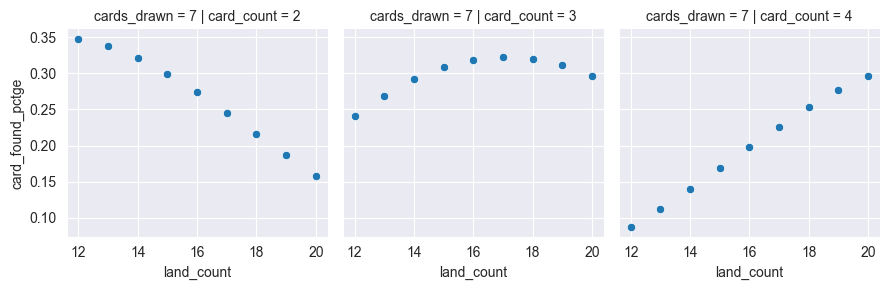

In [78]:
g = sns.FacetGrid(data=ideal_hand_zoom,
                  col='card_count', row='cards_drawn', sharex=False)
g.map_dataframe(sns.scatterplot, x='land_count', y='card_found_pctge')

In [41]:
def df_card_operations(df, cards_drawn_range, card_count_range):
    reduced_card_drawn_df = df.loc[df['cards_drawn'].isin(cards_drawn_range)]
    reduced_card_count_df = reduced_card_drawn_df.loc[reduced_card_drawn_df['card_count'].isin(card_count_range)]
    reduced_group = reduced_card_count_df.groupby(['cards_drawn', 'land_count']).sum()['card_found_pctge'].reset_index()
    reduced_group['card_found_delta_from_max'] = reduced_group['card_found_pctge'] - reduced_group.groupby(['cards_drawn']).transform('max')['card_found_pctge']
    
    return reduced_card_drawn_df, reduced_card_count_df, reduced_group

In [42]:
seven_card_df, reduced_seven_card_df, reduced_seven_card_group = df_card_operations(test_df, [7], [2, 3, 4])

In [46]:
reduced_seven_card_df.head()

,card_found_pctge,land_count,cards_drawn,card_count
18,0.347921,12,7,2
19,0.337754,13,7,2
20,0.321075,14,7,2
21,0.299227,15,7,2
22,0.273579,16,7,2


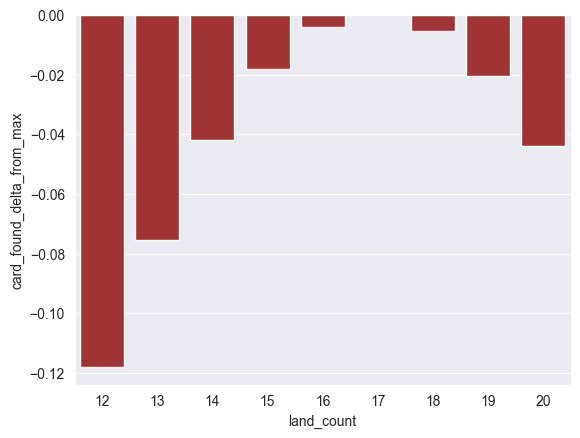

In [82]:
bar_ax = sns.barplot(data=reduced_seven_card_group, x='land_count',
                     y='card_found_delta_from_max',
                     color='firebrick'
                    )
# bar_ax.set_title('2-4 Lands Percentage Delta from 17 Lands')

In [83]:
reduced_seven_card_df.head()

,card_found_pctge,land_count,cards_drawn,card_count
18,0.347921,12,7,2
19,0.337754,13,7,2
20,0.321075,14,7,2
21,0.299227,15,7,2
22,0.273579,16,7,2


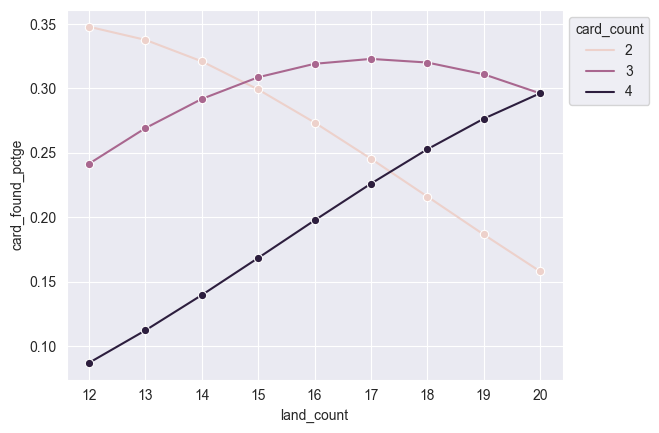

In [84]:
ax = sns.lineplot(data=reduced_seven_card_df, x='land_count', y='card_found_pctge', hue='card_count', marker='o')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'Opening Hand Lands Found Distribution Based on Lands in Deck')

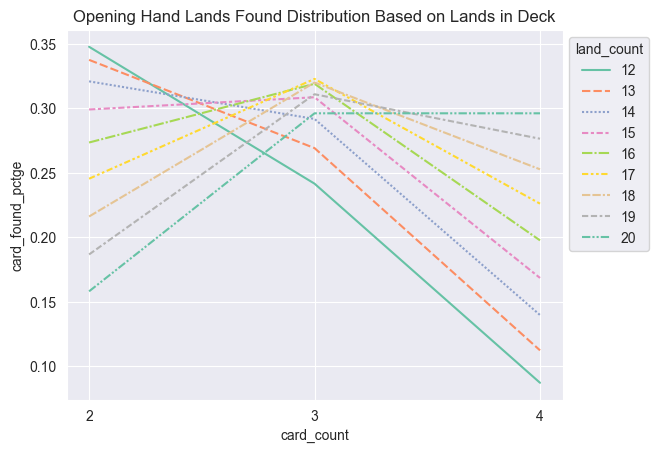

In [85]:
ax = sns.lineplot(data=reduced_seven_card_df,#.loc[seven_card_df['land_count'].isin([16,17,18])],
                  x='card_count', y='card_found_pctge', hue='land_count', 
                  # markers=True, 
                  style='land_count',
                  legend='full',
                  palette='Set2'
                 )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticks([2, 3, 4])
ax.set_title('Opening Hand Lands Found Distribution Based on Lands in Deck')

# below is added for the zoomed in look
# for val in [7, 6, 5, 1, 0]:
#     ax.lines.pop(val)

# h,l = ax.get_legend_handles_labels()
# ax.legend(h[2:5],l[2:5], bbox_to_anchor=(1, 1), loc='upper left')#, borderaxespad=0.)


# ax.figure

In [86]:
print(ax.axes.get_lines())

<a list of 18 Line2D objects>


In [88]:
turn_three_df, reduced_three_df, reduced_three_group = df_card_operations(test_df, [9, 10], [3, 4, 5])

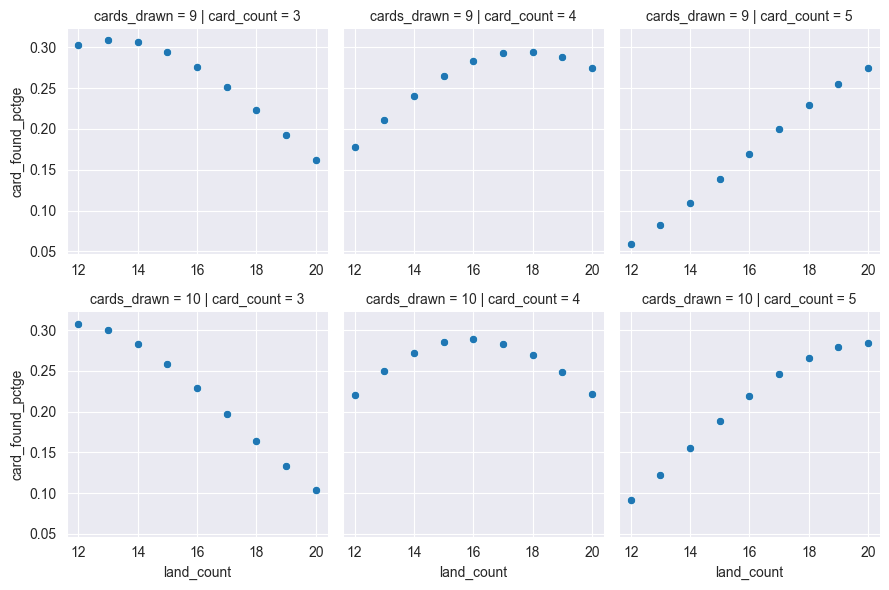

In [89]:
g = sns.FacetGrid(data=reduced_three_df, col='card_count', row='cards_drawn', sharex=False)
g.map_dataframe(sns.scatterplot, x='land_count', y='card_found_pctge')

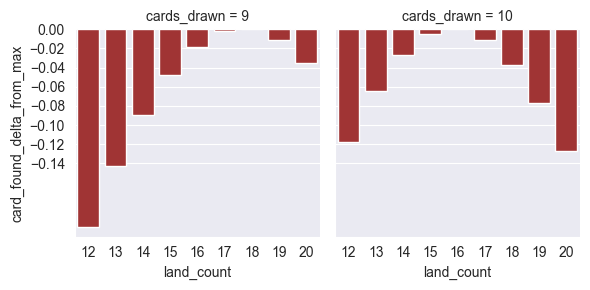

In [57]:
g = sns.FacetGrid(data=reduced_three_group, col='cards_drawn', sharex=False, aspect=1)
g.map_dataframe(sns.barplot, x='land_count',
                     y='card_found_delta_from_max',
                     color='firebrick',
                
                    )
g.set(yticks=np.arange(0, -.15, -.02))
# bar_ax.set_title('Delta from Max Percentage for a 7 Card Hand with 2-4 Lands')

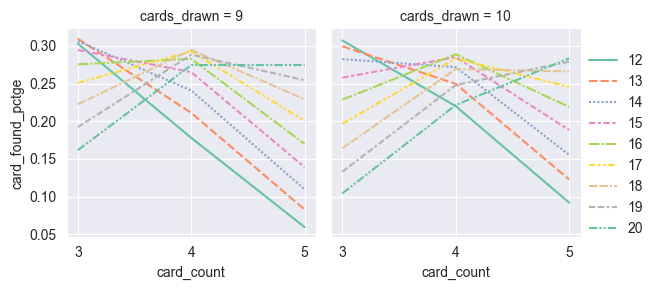

In [58]:
g = sns.FacetGrid(data=reduced_three_df, col='cards_drawn', sharex=False)


ax = g.map_dataframe(sns.lineplot, 
                  x='card_count', y='card_found_pctge', hue='land_count', 
                  # markers=True, 
                  style='land_count',
                  legend='full',
                  palette='Set2'
                 )
g.add_legend()
g.set(xticks=[3, 4, 5])
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# ax.set_xticks([2, 3, 4])
# ax.set_title('Opening Hand Lands Found Distribution Based on Lands in Deck')

# Turn 5

In [59]:
turn_five_df, reduced_five_df, reduced_five_group = df_card_operations(test_df, [11, 12], [4, 5, 6])

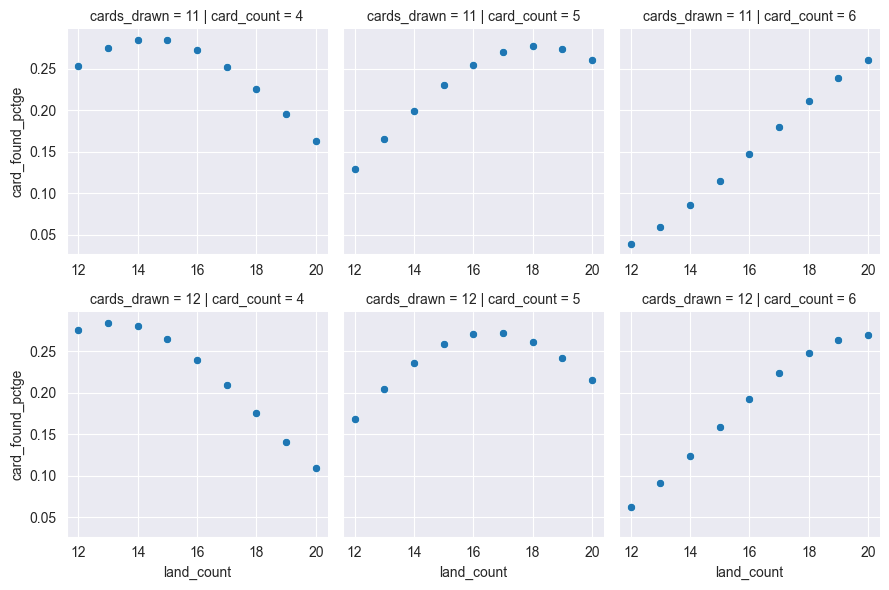

In [90]:
g = sns.FacetGrid(data=reduced_five_df, col='card_count', row='cards_drawn', sharex=False)
g.map_dataframe(sns.scatterplot, x='land_count', y='card_found_pctge')

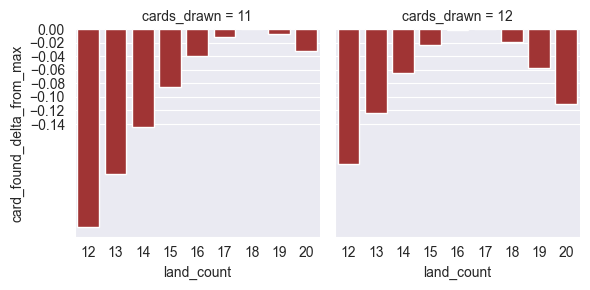

In [61]:
g = sns.FacetGrid(data=reduced_five_group, col='cards_drawn', sharex=False, aspect=1)
g.map_dataframe(sns.barplot, x='land_count',
                     y='card_found_delta_from_max',
                     color='firebrick',
                
                    )
g.set(yticks=np.arange(0, -.15, -.02))
# bar_ax.set_title('Delta from Max Percentage for a 7 Card Hand with 2-4 Lands')

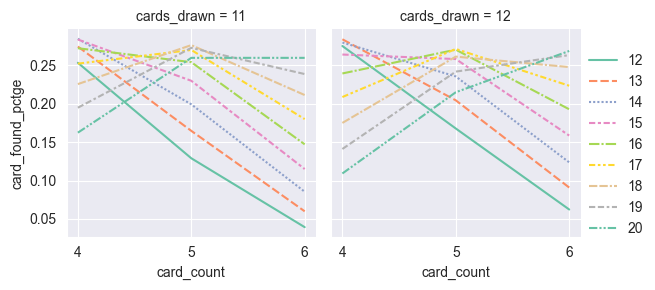

In [62]:
g = sns.FacetGrid(data=reduced_five_df, col='cards_drawn', sharex=False)


ax = g.map_dataframe(sns.lineplot, 
                  x='card_count', y='card_found_pctge', hue='land_count', 
                  # markers=True, 
                  style='land_count',
                  legend='full',
                  palette='Set2'
                 )
g.add_legend()
g.set(xticks=[4, 5, 6])

# Longer Games

In [91]:
turn_seven_df, reduced_seven_df, reduced_seven_group = df_card_operations(test_df, [13, 14], [4, 5, 6])

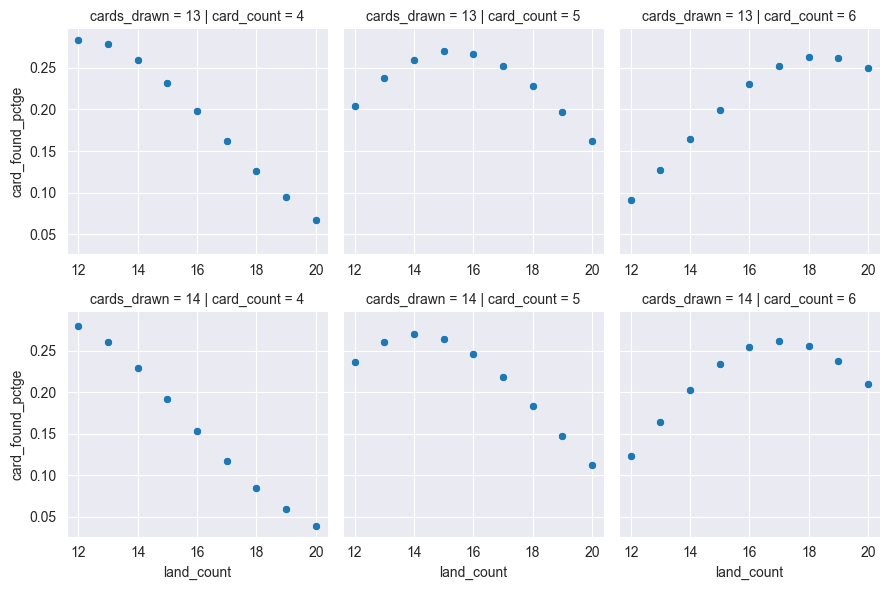

In [92]:
g = sns.FacetGrid(data=reduced_seven_df, col='card_count', row='cards_drawn', sharex=False)
g.map_dataframe(sns.scatterplot, x='land_count', y='card_found_pctge')